In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'heartbeat:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F29414%2F37484%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240314%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240314T052012Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dba5c514d1c4928a9d664374dea08e04075e1d4bd308033b134c4390432b0222d57fd842ce8bb1085a4c4e53f72e0430bad20b84712388ee1cdec2383573e01ad3e8f8639bf29a62a4b62ca94f97c2819655e556b584d002b5de5dc64a2b9485b38a4f5edf4e4283e77ec84bde960c910cfb91596fe6f2ca9f31cb318260f99cc8135386cbe82d2c7918947ef54e63a761ccf0d96d8df4445716f8aa1cd26e2e3ed55419d0891aa1c2094039bac5f88a3ebfa58ddf35ec23b86612582f192afdd288f5ac8a3afcaf7927acc1755843adcb8f830ab1b092038675218f2816e8afeb95230539ec781ea072a650b74231e6642692040a06ed3ae3d2818bfb541092d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 103633768 bytes downloaded
Downloaded and uncompressed: heartbeat
Data source import complete.


# ECG prediction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools
%matplotlib inline


np.random.seed(0) # so our results will be copyable

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report
from sklearn.metrics import classification_report

import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Conv1D, MaxPool1D, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import mlxtend

In [3]:
random_seed = 0

### 2. Data preparation

Loading the data

In [4]:
train = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', header=None)
test = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', header=None)

Looking at the information of our data

In [5]:
train.describe()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890360,0.758160,0.423972,0.219104,0.201127,0.210399,0.205808,0.201773,0.198691,0.196757,...,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807,0.473376
std,0.240909,0.221813,0.227305,0.206878,0.177058,0.171909,0.178481,0.177240,0.171778,0.168357,...,0.044154,0.042089,0.040525,0.038651,0.037193,0.036255,0.034789,0.032865,0.031924,1.143184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.991342,0.826013,0.429472,0.166000,0.147878,0.158798,0.145324,0.144424,0.150000,0.148734,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.910506,0.578767,0.341727,0.258993,0.287628,0.298237,0.295391,0.290832,0.283636,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


In [6]:
train.shape

(87554, 188)

Plotting our data to understand whether it's biased or not

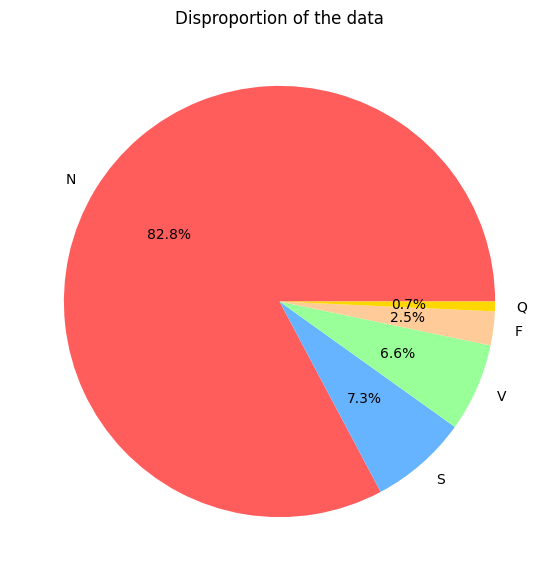

In [7]:
plt.figure(figsize=(7, 7))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(train[187].value_counts(), labels=['N', 'S', 'V', 'F', 'Q'], autopct='%1.1f%%', colors = ['#FF5C5C', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700']
)
plt.title('Disproportion of the data')
plt.show()

In [8]:

df_0=(train[train[187]==0]).sample(n=20000,random_state=42)
df_1=train[train[187]==1]
df_2=train[train[187]==2]
df_3=train[train[187]==3]
df_4=train[train[187]==4]


df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=random_seed+1)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=random_seed+2)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=random_seed+3)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=random_seed+4)

train=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

Plotting the dataset after resampling

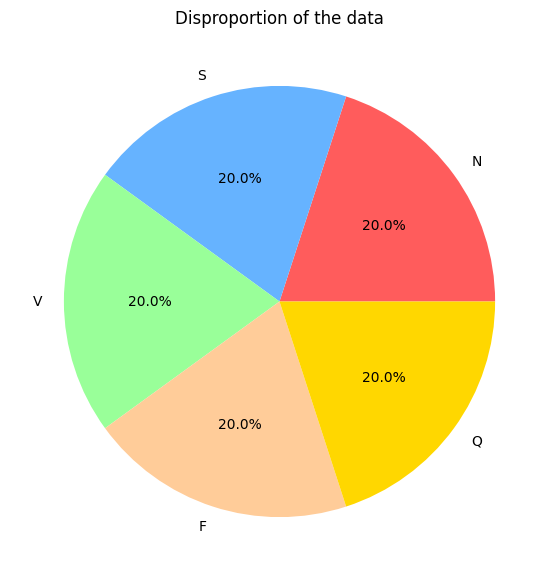

In [9]:
plt.figure(figsize=(7, 7))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(train[187].value_counts(), labels=['N', 'S', 'V', 'F', 'Q'], autopct='%1.1f%%', colors = ['#FF5C5C', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700']
)
plt.title('Disproportion of the data')
plt.show()

Our data is ready to be fitted to our model after resampling.

Creating x and y labels from our dataset

In [10]:
X_train, y_train = train.iloc[:, :187], train[187]
X_test, y_test = test.iloc[:, :187], test[187] #I didn't resample test dataset because it have to stay baised as it was to give right accuracy and f1 score

Also we can visualize the diffrently labeled data in our dataset

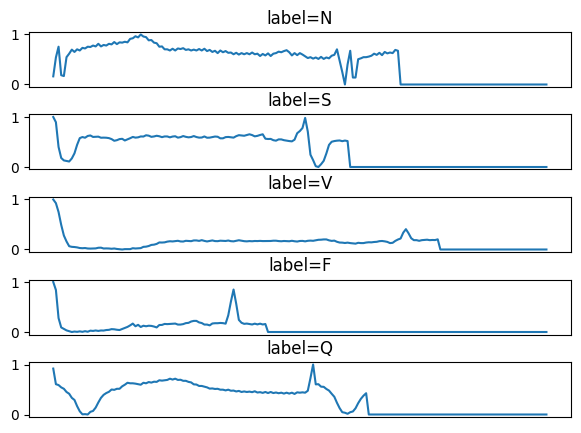

In [11]:
labels = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}
fig, ax = plt.subplots(5,1, figsize=(7,5), gridspec_kw={'hspace': 0.5})
for i in range(5):
    ax[i].plot(X_train[y_train==i].iloc[0])
    ax[i].set_title(f'label={labels[i]}')
    ax[i].set_xticks([])

### Data normalization

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

Plotting after normalization. As you can see, the amplitudes of different ECG examples are the same, which helps to prevent biases caused by differences in magnitude.

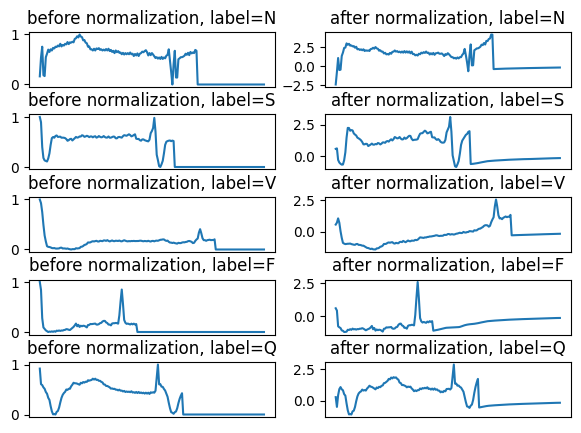

In [13]:
labels = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}
fig, ax = plt.subplots(5,2, figsize=(7,5), gridspec_kw={'hspace': 0.5})
for i in range(5):
    ax[i][0].plot(X_train[y_train==i].iloc[0])
    ax[i][1].plot(X_train_norm[y_train==i][0])
    ax[i][0].set_title(f'before normalization, label={labels[i]}')
    ax[i][0].set_xticks([])
    ax[i][1].set_xticks([])
    ax[i][1].set_title(f'after normalization, label={labels[i]}')

### 3.CNN model

Building a convolutional neural network with TensorFlow

In [14]:
(X_train.shape[1],1)

(187, 1)

In [15]:
model = Sequential([
    Input(shape=(X_train_norm.shape[1], 1)),
    Conv1D(128, 11, activation='relu', padding='Same'),
    MaxPool1D(pool_size=3, strides=2, padding='same'),
    Conv1D(64, 3, activation='relu', padding='Same'),
    MaxPool1D(pool_size=3, strides=2, padding='same'),
    Conv1D(64, 3, activation='relu', padding='Same'),
    MaxPool1D(pool_size=3, strides=2, padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='linear')
])

In [16]:
model.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(from_logits=True))

In [17]:
model.fit(X_train_norm, y_train, epochs=16, batch_size=32)

Epoch 1/16
3125/3125 [==============================] - 96s 30ms/step - loss: 0.2317
Epoch 2/16
3125/3125 [==============================] - 91s 29ms/step - loss: 0.0875
Epoch 3/16
3125/3125 [==============================] - 93s 30ms/step - loss: 0.0555
Epoch 4/16
3125/3125 [==============================] - 90s 29ms/step - loss: 0.0437
Epoch 5/16
3125/3125 [==============================] - 91s 29ms/step - loss: 0.0361
Epoch 6/16
3125/3125 [==============================] - 90s 29ms/step - loss: 0.0300
Epoch 7/16
3125/3125 [==============================] - 90s 29ms/step - loss: 0.0260
Epoch 8/16
3125/3125 [==============================] - 89s 29ms/step - loss: 0.0238
Epoch 9/16
3125/3125 [==============================] - 88s 28ms/step - loss: 0.0219
Epoch 10/16
3125/3125 [==============================] - 88s 28ms/step - loss: 0.0199
Epoch 11/16
3125/3125 [==============================] - 88s 28ms/step - loss: 0.0173
Epoch 12/16
3125/3125 [==============================] - 88s 28

### 4. Interpretation of the results

In [18]:
pred = model.predict(X_test_norm)
pred_after_softmax = tf.nn.softmax(pred)
pred_after_softmax = pred_after_softmax.numpy() #convert to numpy to use masking further
y_test_pred = pred_after_softmax.argmax(axis=1) #find result in every case
print(f'Test set accuracy is {round((y_test_pred == y_test).sum() / y_test.shape[0] * 100, 2)}%')

2737/2737 [==============================] - 22s 8ms/step
Test set accuracy is 98.7%


In [19]:
pred = model.predict(X_train_norm)
pred_after_softmax = tf.nn.softmax(pred)
pred_after_softmax = pred_after_softmax.numpy() #convert to numpy to use masking further
y_train_pred = pred_after_softmax.argmax(axis=1) #find result in every case
print(f'Train set accuracy is {round((y_train_pred == y_train).sum() / y_train.shape[0] * 100, 2)}%')

3125/3125 [==============================] - 25s 8ms/step
Train set accuracy is 99.85%


The accuracy of the model in the training set is 97.4%, and it is 99.75% in the training set. It means that it wasn't underfitted or overfitted and shows good results in our data. But when we have bad data, it's not enough to get accuracy, but it's important to look at prediction, recall, and F1 score.

In [20]:
class_names = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

Normalized confusion matrix


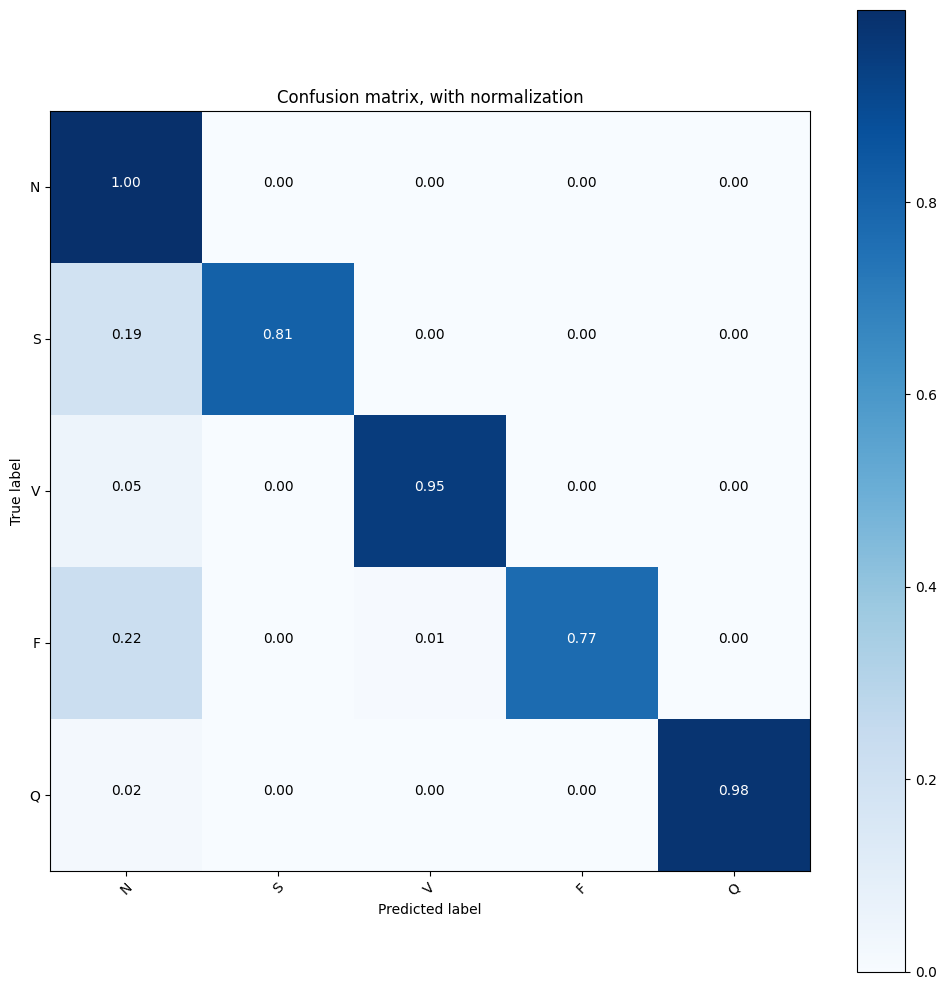

              precision    recall  f1-score   support

           N       1.00      0.98      0.99     72471
           S       0.81      1.00      0.90      2223
           V       0.95      1.00      0.97      5788
           F       0.77      1.00      0.87       641
           Q       0.98      1.00      0.99      6431

    accuracy                           0.99     87554
   macro avg       0.90      1.00      0.94     87554
weighted avg       0.99      0.99      0.99     87554



In [21]:
.;l"?.;l/';l'/
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """The function prints and plots the confusion matrix."""
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_pred, y_test)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix, with normalization')
plt.show()

weighted_f1 = f1_score(y_test, y_test_pred, average='weighted')
print(classification_report(y_test, y_test_pred, target_names=class_names.values()))